In [ ]:
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Charger les données historiques
historical_data_path = "/content/drive/My Drive/AirLiquideJL/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet"
historical_df = pd.read_parquet(historical_data_path)


In [ ]:
# Vérifier datetime
historical_df.index = pd.to_datetime(historical_df.index)

# Normalisation des prix
scaler = MinMaxScaler()
historical_df["price"] = scaler.fit_transform(historical_df[["price"]])

In [ ]:
# Création des séquences temporelles pour XGBoost
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)
# Utilisation des 24 dernières heures pour prédire la suivante
window_size = 24
X, y = create_sequences(historical_df["price"].values, window_size)

# Transformer en format 2D pour XGBoost
X = X.reshape(X.shape[0], -1)  # (samples, window_size)

In [ ]:
# Séparer en train/test (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Taille des données d'entraînement : {X_train.shape}, Taille des données de test : {X_test.shape}")


Taille des données d'entraînement : (28032, 24), Taille des données de test : (7008, 24)


In [ ]:
!pip uninstall -y scikit-learn xgboost
!pip install scikit-learn==1.2.2 xgboost==1.7.3

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: xgboost 1.7.3
Uninstalling xgboost-1.7.3:
  Successfully uninstalled xgboost-1.7.3
  Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached xgboost-1.7.3-py3-none-manylinux2014_x86_64.whl.metadata (1.9 kB)
Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
Using cached xgboost-1.7.3-py3-none-manylinux2014_x86_64.whl (193.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [ ]:
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Sauvegarder le modèle
import joblib
joblib.dump(xgb_model, "xgb_model_original.pkl")

['xgb_model_original.pkl']

MAE Train : 0.006988 | MAE Test : 0.007140
RMSE Train : 0.009920 | RMSE Test : 0.012367


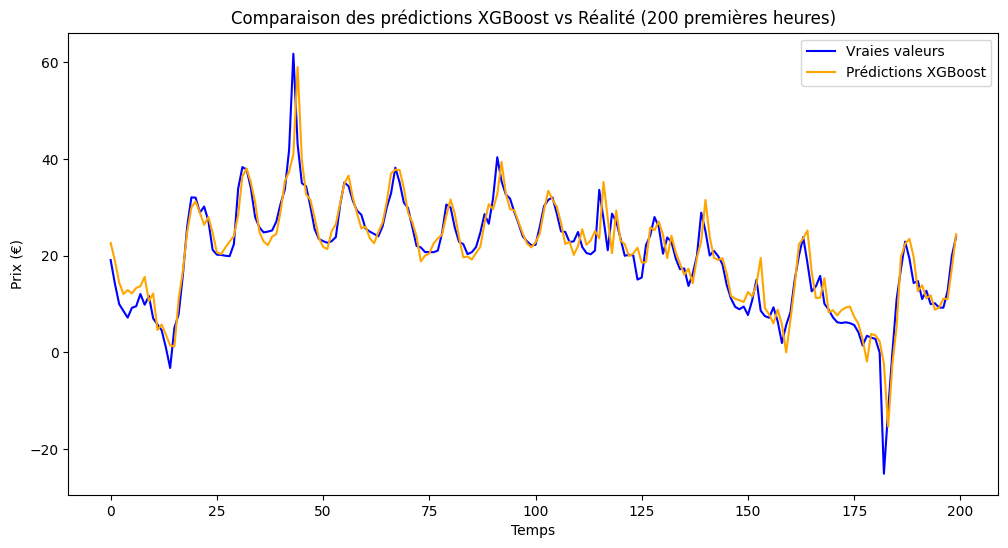

In [ ]:
# Prédictions et évaluation
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Inverser la normalisation des prédictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test.reshape(-1, 1))

# Calcul des métriques
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"MAE Train : {mae_train:.6f} | MAE Test : {mae_test:.6f}")
print(f"RMSE Train : {rmse_train:.6f} | RMSE Test : {rmse_test:.6f}")

# Visualisation des prédictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:200], label="Vraies valeurs", color="blue")
plt.plot(y_pred_test_inv[:200], label="Prédictions XGBoost", color="orange")
plt.title("Comparaison des prédictions XGBoost vs Réalité (200 premières heures)")
plt.xlabel("Temps")
plt.ylabel("Prix (€)")
plt.legend()
plt.show()


In [ ]:
import plotly.express as px
import pandas as pd
# Faire des prédictions avec le modèle XGBoost
y_pred_xgb = xgb_model.predict(X_test)

# Inverser la normalisation pour obtenir les valeurs réelles
y_pred_xgb_inv = scaler.inverse_transform(y_pred_xgb.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Créer un DataFrame pour la visualisation
df_plot = pd.DataFrame({
    "Heures": range(len(y_test_inv)),
    "Vraies valeurs": y_test_inv.flatten(),
    "Prédictions XGBoost": y_pred_xgb_inv.flatten()
})

# Tracer avec Plotly
fig = px.line(df_plot, x="Heures", y=["Vraies valeurs", "Prédictions XGBoost"],
              title="Comparaison des prédictions XGBoost vs Réalité sur toutes les heures")
fig.show()


# Data augmentation

In [ ]:
import numpy as np

    # Ajoute un bruit gaussien à la série temporelle
def jittering(data, noise_level=0.01):
    return data + np.random.normal(0, noise_level, size=data.shape)

    # Multiplie la série temporelle par un facteur aléatoire
def scaling(data, scale_factor=0.1):
    factor = np.random.uniform(1 - scale_factor, 1 + scale_factor)
    return data * factor

    # Prend une sous-partie de la série temporelle
def window_slicing(data, slice_ratio=0.1):
    slice_size = int(len(data) * (1 - slice_ratio))
    start_idx = np.random.randint(0, len(data) - slice_size)
    return data[start_idx:start_idx + slice_size]

In [ ]:
# Appliquer l'augmentation sur la série
augmentation_method = jittering
X_train_augmented = np.array([augmentation_method(x) for x in X_train])

In [ ]:
X_train_augmented = X_train_augmented.reshape(X_train_augmented.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)  # Garder X_test inchangé


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Définir et entraîner le modèle XGBoost
xgb_model_augmented = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model_augmented.fit(X_train_augmented, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
# Sauvegarder le modèle AVEC augmentation jittering
joblib.dump(xgb_model_augmented, "xgb_model_augmented_jittering.pkl")

['xgb_model_augmented_jittering.pkl']

In [ ]:
# Prédictions
y_pred_xgb_aug = xgb_model_augmented.predict(X_test)

# Évaluation des performances
mae_aug = mean_absolute_error(y_test, y_pred_xgb_aug)
rmse_aug = np.sqrt(mean_squared_error(y_test, y_pred_xgb_aug))

print(f"MAE XGBoost avec augmentation : {mae_aug:.6f} | RMSE : {rmse_aug:.6f}")


MAE XGBoost avec augmentation : 0.007915 | RMSE : 0.013112


In [ ]:
# Recharger le modèle original avant d'utiliser predict()
xgb_model = joblib.load("xgb_model_original.pkl")

# Prédictions avec le modèle original
y_pred_xgb_base = xgb_model.predict(X_test)

# Prédictions avec le modèle augmenté
y_pred_xgb_aug = xgb_model_augmented.predict(X_test)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Évaluer le modèle SANS augmentation
mae_base = mean_absolute_error(y_test, y_pred_xgb_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_xgb_base))

# Évaluer le modèle AVEC augmentation
mae_aug = mean_absolute_error(y_test, y_pred_xgb_aug)
rmse_aug = np.sqrt(mean_squared_error(y_test, y_pred_xgb_aug))

# Affichage des résultats
print(f"MAE XGBoost SANS augmentation : {mae_base:.6f} | RMSE : {rmse_base:.6f}")
print(f"MAE XGBoost AVEC augmentation : {mae_aug:.6f} | RMSE : {rmse_aug:.6f}")


MAE XGBoost SANS augmentation : 0.007140 | RMSE : 0.012367
MAE XGBoost AVEC augmentation : 0.007915 | RMSE : 0.013112


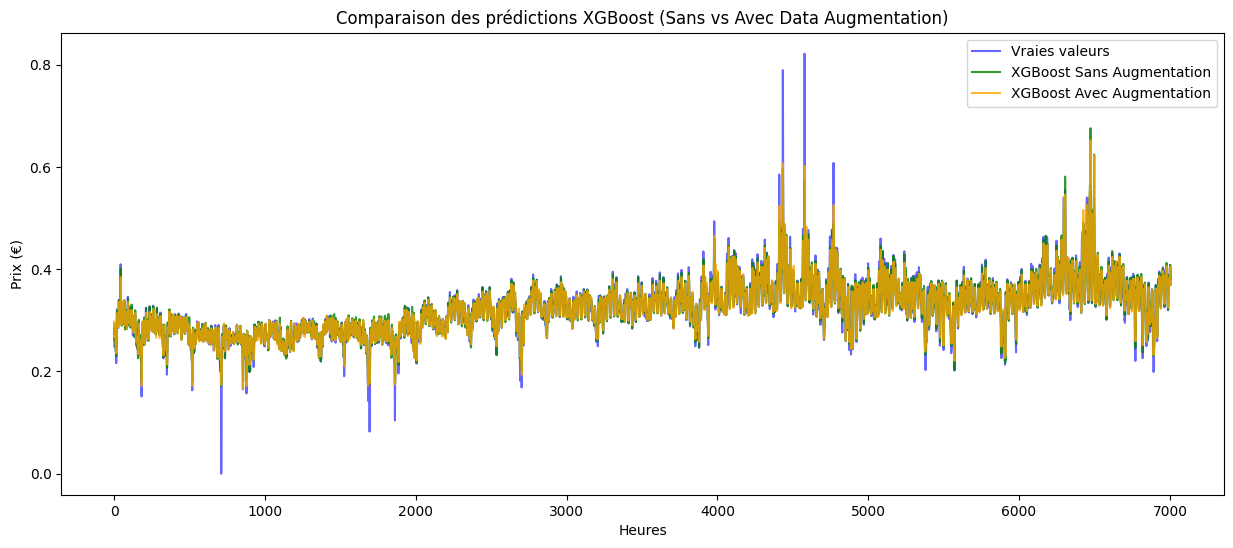

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(y_test, label="Vraies valeurs", color="blue", alpha=0.6)
plt.plot(y_pred_xgb_base, label="XGBoost Sans Augmentation", color="green", alpha=0.8)
plt.plot(y_pred_xgb_aug, label="XGBoost Avec Augmentation", color="orange", alpha=0.8)
plt.title("Comparaison des prédictions XGBoost (Sans vs Avec Data Augmentation)")
plt.xlabel("Heures")
plt.ylabel("Prix (€)")
plt.legend()
plt.show()


In [ ]:
# Appliquer l'augmentation sur la série
augmentation_method = scaling
X_train_augmented = np.array([augmentation_method(x) for x in X_train])

X_train_augmented = X_train_augmented.reshape(X_train_augmented.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)  # Garder X_test inchangé

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Définir et entraîner le modèle XGBoost
xgb_model_augmented_scaling = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model_augmented_scaling.fit(X_train_augmented, y_train)

# Sauvegarder le modèle AVEC augmentation jittering
joblib.dump(xgb_model_augmented_scaling, "xgb_model_augmented_scaling.pkl")

# Prédictions
y_pred_xgb_aug_scaling = xgb_model_augmented_scaling.predict(X_test)

# Évaluation des performances
mae_aug = mean_absolute_error(y_test, y_pred_xgb_aug_scaling)
rmse_aug = np.sqrt(mean_squared_error(y_test, y_pred_xgb_aug_scaling))

print(f"MAE XGBoost avec scaling augmentation : {mae_aug:.6f} | RMSE : {rmse_aug:.6f}")

MAE XGBoost avec scaling augmentation : 0.012317 | RMSE : 0.017197


In [ ]:
# Appliquer l'augmentation window_slicing sur la série
augmentation_method = window_slicing
X_train_augmented = np.array([augmentation_method(x) for x in X_train])

def window_slicing_fixed(data, slice_ratio=0.1, window_size=24):
    slice_size = int(len(data) * (1 - slice_ratio))
    start_idx = np.random.randint(0, len(data) - slice_size)
    sliced = data[start_idx:start_idx + slice_size]

    # Remplir ou tronquer pour toujours garder 24 features
    if len(sliced) < window_size:
        pad = np.zeros(window_size - len(sliced))  # Padding si trop court
        sliced = np.concatenate([sliced, pad])
    elif len(sliced) > window_size:
        sliced = sliced[:window_size]  # Tronquer si trop long

    return sliced

# Reshape pour XGBoost (passage en 2D)
X_train_augmented = np.array([window_slicing_fixed(x) for x in X_train])
X_test = X_test.reshape(X_test.shape[0], -1)  # Garder X_test inchangé

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

# Définir et entraîner le modèle XGBoost
xgb_model_augmented_window_slicing = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model_augmented_window_slicing.fit(X_train_augmented, y_train)

# Sauvegarder le modèle avec window_slicing
joblib.dump(xgb_model_augmented_window_slicing, "xgb_model_augmented_window_slicing.pkl")

# Prédictions
y_pred_xgb_aug_window_slicing = xgb_model_augmented_window_slicing.predict(X_test)

# Évaluation des performances
mae_aug_window_slicing = mean_absolute_error(y_test, y_pred_xgb_aug_window_slicing)
rmse_aug_window_slicing = np.sqrt(mean_squared_error(y_test, y_pred_xgb_aug_window_slicing))

print(f"MAE XGBoost avec window slicing augmentation : {mae_aug_window_slicing:.6f} | RMSE : {rmse_aug_window_slicing:.6f}")


MAE XGBoost avec window slicing augmentation : 0.016044 | RMSE : 0.024290


# Données synthétiques


In [ ]:
import pandas as pd
import numpy as np
import os

# Définir le chemin du dossier contenant les fichiers Parquet des scénarios synthétiques
synthetic_data_path = "/content/drive/My Drive/AirLiquideJL/scenarios synthetiques/prix/"

# Lister les fichiers disponibles
files = [f for f in os.listdir(synthetic_data_path) if f.endswith(".parquet")]

# Charger et concaténer tous les fichiers
df_list = [pd.read_parquet(os.path.join(synthetic_data_path, file)) for file in files]
synthetic_df = pd.concat(df_list, ignore_index=True)

# Vérifier l'aperçu des données
print("Aperçu des données synthétiques :")
print(synthetic_df.head())


Aperçu des données synthétiques :
   price  dayofweek  hourofday
0  31.66          0          0
1  31.06          0          1
2  27.81          0          2
3  27.54          0          3
4  25.04          0          4


In [ ]:
sample_fraction = 0.1  # Garde 10% des données
synthetic_df = synthetic_df.iloc[:int(len(synthetic_df) * sample_fraction)]

# Générer des dates normalement maintenant que la taille est réduite
start_date = "2023-01-01 00:00:00"
synthetic_df["datetime"] = pd.date_range(start=start_date, periods=len(synthetic_df), freq="H")

# Définir datetime comme index
synthetic_df.set_index("datetime", inplace=True)


<ipython-input-24-973a94239765>:6: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

<ipython-input-24-973a94239765>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
synthetic_df["price"] = scaler.fit_transform(synthetic_df[["price"]])

In [ ]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])  # Les `window_size` valeurs précédentes
        y.append(data[i+window_size])    # La valeur suivante
    return np.array(X), np.array(y)

window_size = 24  # Utiliser les 24 dernières heures pour prédire la suivante
X_synthetic, y_synthetic = create_sequences(synthetic_df["price"].values, window_size)

# Reshape pour XGBoost (transformer en 2D)
X_synthetic = X_synthetic.reshape(X_synthetic.shape[0], -1)

print("Taille des données pour XGBoost :", X_synthetic.shape)

Taille des données pour XGBoost : (538113, 24)


In [ ]:
from sklearn.model_selection import train_test_split

split_index = int(len(X_synthetic) * 0.8)  # 80% train, 20% test
X_train_syn, X_test_syn = X_synthetic[:split_index], X_synthetic[split_index:]
y_train_syn, y_test_syn = y_synthetic[:split_index], y_synthetic[split_index:]

print(f" Taille Train : {X_train_syn.shape}, Taille Test : {X_test_syn.shape}")

 Taille Train : (430490, 24), Taille Test : (107623, 24)


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Définir et entraîner le modèle XGBoost
xgb_model_synthetic = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model_synthetic.fit(X_train_syn, y_train_syn)

# Sauvegarder le modèle entraîné avec les données synthétiques
import joblib
joblib.dump(xgb_model_synthetic, "xgb_model_synthetic.pkl")

print(" Modèle XGBoost (données synthétiques) sauvegardé avec succès !")


 Modèle XGBoost (données synthétiques) sauvegardé avec succès !


In [ ]:
# Charger le modèle si nécessaire
xgb_model_synthetic = joblib.load("xgb_model_synthetic.pkl")

# Faire des prédictions
y_pred_synthetic = xgb_model_synthetic.predict(X_test_syn)

# Calcul des métriques
mae_synthetic = mean_absolute_error(y_test_syn, y_pred_synthetic)
rmse_synthetic = np.sqrt(mean_squared_error(y_test_syn, y_pred_synthetic))

print(f"MAE XGBoost (données synthétiques) : {mae_synthetic:.6f} | RMSE : {rmse_synthetic:.6f}")


MAE XGBoost (données synthétiques) : 0.007500 | RMSE : 0.010857


In [ ]:
import plotly.express as px
import pandas as pd

# Créer un DataFrame pour la visualisation
df_plot = pd.DataFrame({
    "Heures": range(len(y_test_syn)),
    "Vraies valeurs (Synthétiques)": y_test_syn.flatten(),
    "Prédictions XGBoost (Synthétiques)": y_pred_synthetic.flatten()
})

# Tracer avec Plotly
fig = px.line(df_plot, x="Heures", y=["Vraies valeurs (Synthétiques)", "Prédictions XGBoost (Synthétiques)"],
              title="Comparaison des prédictions XGBoost vs Réalité (Données Synthétiques)",
              labels={"value": "Prix (€)", "variable": "Légende"})
fig.show()



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import joblib

# Charger les modèles
models = {
    "Sans Augmentation": joblib.load("xgb_model_original.pkl"),
    "Jittering": joblib.load("xgb_model_augmented_jittering.pkl"),
    "Scaling": joblib.load("xgb_model_augmented_scaling.pkl"),
    "Window Slicing": joblib.load("xgb_model_augmented_window_slicing.pkl"),
    "Données Synthétiques": joblib.load("xgb_model_synthetic.pkl")
}

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Dictionnaire pour stocker les résultats
results = {}

# Boucle sur chaque modèle
for name, model in models.items():
    print(f"Prédiction avec : {name}")

    # Faire des prédictions
    y_pred = model.predict(X_test)

    # Calculer les métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Stocker les résultats
    results[name] = {"MAE": mae, "RMSE": rmse}

# Afficher tous les résultats
print("\nComparaison des modèles :")
for name, metrics in results.items():
    print(f"{name}: MAE = {metrics['MAE']:.6f} | RMSE = {metrics['RMSE']:.6f}")


Prédiction avec : Sans Augmentation
Prédiction avec : Jittering
Prédiction avec : Scaling
Prédiction avec : Window Slicing
Prédiction avec : Données Synthétiques

Comparaison des modèles :
Sans Augmentation: MAE = 0.007140 | RMSE = 0.012367
Jittering: MAE = 0.007915 | RMSE = 0.013112
Scaling: MAE = 0.012317 | RMSE = 0.017197
Window Slicing: MAE = 0.016044 | RMSE = 0.024290
Données Synthétiques: MAE = 0.006277 | RMSE = 0.009223


In [ ]:
import plotly.express as px
import pandas as pd

# Créer un DataFrame à partir des résultats stockés dans `results`
df_results = pd.DataFrame(results).T  # Transposer pour que les modèles soient en ligne
df_results["Méthode"] = df_results.index  # Ajouter une colonne pour l'axe X

# Tracer un graphique en barres groupées
fig = px.bar(df_results, x="Méthode", y=["MAE", "RMSE"],
             title="Comparaison des erreurs (MAE & RMSE) pour chaque augmentation",
             labels={"index": "Méthodes de Data Augmentation", "value": "Erreur"},
             barmode="group",  # Mode "group" pour afficher les barres côte à côte
             text_auto=True)  # Afficher les valeurs sur les barres

# Afficher le graphique
fig.show()


In [ ]:
# Créer un DataFrame contenant toutes les prédictions
df_predictions = pd.DataFrame({"Heures": range(len(y_test))})
df_predictions["Vraies valeurs"] = y_test

for name, model in models.items():
    df_predictions[f"Prédictions {name}"] = model.predict(X_test)

# Tracer avec Plotly
fig = px.line(df_predictions, x="Heures", y=["Vraies valeurs"] + [f"Prédictions {name}" for name in models.keys()],
              title="Comparaison des prédictions XGBoost (Sans vs Différentes Augmentations)",
              labels={"value": "Prix (€)", "variable": "Légende"})
fig.show()
